<a href="https://colab.research.google.com/github/chjohnso-um/chjohnso-um-CSC-587/blob/main/Code_Based_on_Code_By_Corey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ChatGPT Generated Code Based On Corey's Code
Note: Patience. It takes a long time to execute.


=== Feature Selection Comparison Results ===
  Feature_Selection  Accuracy  Precision  Recall        F1       AUC
0                MI  0.714286   0.750000   0.750  0.750000  0.708333
1            Boruta  0.714286   0.750000   0.750  0.750000  0.770833
2             LASSO  0.928571   0.888889   1.000  0.941176  0.979167
3              SHAP  0.642857   0.666667   0.750  0.705882  0.666667
4       Permutation  0.285714   0.375000   0.375  0.375000  0.291667

=== Final Model Comparison Results ===
          Model  Accuracy  Precision  Recall        F1       AUC
0       XGBoost  0.642857   0.666667    0.75  0.705882  0.666667
1  RandomForest  0.857143   0.800000    1.00  0.888889  0.854167
2           SVM  0.714286   0.750000    0.75  0.750000  0.729167

Feature selection and model comparison results saved!


<ipython-input-11-01c347008364>:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature_Selection', y='AUC', data=fs_results_df, palette='Blues_d')


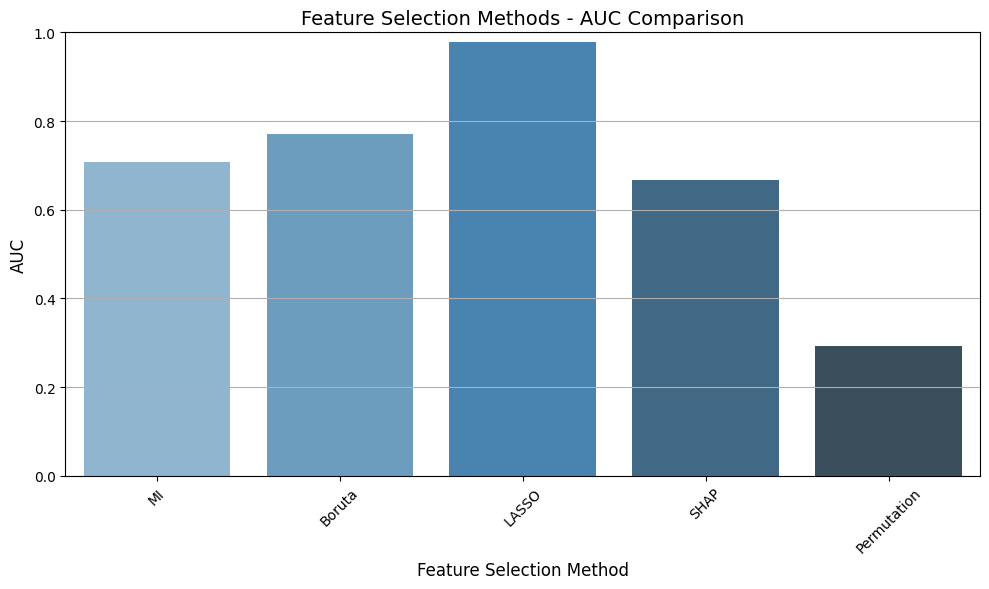

<ipython-input-11-01c347008364>:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=model_results_df, palette='Greens_d')


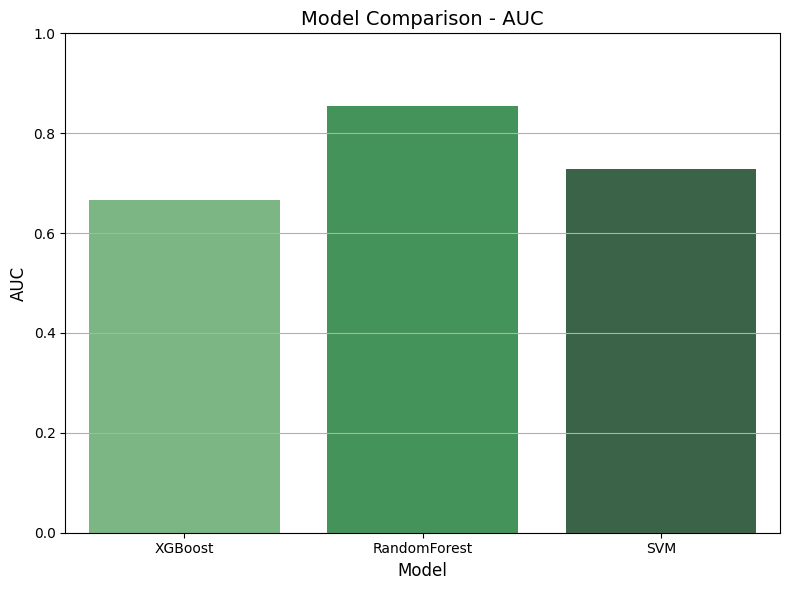

In [11]:
#ChatGPT Generated Code Based On Corey's Code
#Note: Patience. It takes a long time to execute.

# --- 1. Imports ---
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score)
from boruta import BorutaPy

# --- 2. Configuration ---
SELECT_DATASET = 'BL'   # Options: 'BL', 'V06', 'BL_to_V06'
INITIAL_MODEL = 'XGBoost' # Options: 'XGBoost', 'RandomForest', 'SVM'
BEST_FEATURE_SELECTION = 'SHAP'  # Will update after FS evaluation
save_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# --- 3. Load Data ---
bl_df = pd.read_csv(save_dir + 'fbni_shared_cols_BL.csv')
v06_df = pd.read_csv(save_dir + 'fbni_shared_cols_V06.csv')

X_bl = bl_df.drop(columns=['Class'])
y_bl = LabelEncoder().fit_transform(bl_df['Class'])

X_v06 = v06_df.drop(columns=['Class'])
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])

scaler = StandardScaler()
X_bl_scaled = scaler.fit_transform(X_bl)
X_v06_scaled = scaler.transform(X_v06)

# --- 4. Feature Selection Functions ---
def select_top20_mi(X, y, feature_names):
    from sklearn.feature_selection import mutual_info_classif
    mi = mutual_info_classif(X, y, random_state=42)
    return list(pd.Series(mi, index=feature_names).sort_values(ascending=False).head(20).index)

def select_top20_boruta(X, y, feature_names):
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=5)
    boruta = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
    boruta.fit(X, y)
    selected = np.array(feature_names)[boruta.support_]
    return list(selected[:20])

def select_top20_lasso(X, y, feature_names):
    lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
    lasso.fit(X, y)
    coef = np.abs(lasso.coef_[0])
    return list(pd.Series(coef, index=feature_names).sort_values(ascending=False).head(20).index)

def select_top20_shap(X, feature_names, model):
    if isinstance(model, XGBClassifier):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X)
        shap_importance = np.abs(shap_values.values).mean(axis=0)
        shap_importance_series = pd.Series(shap_importance, index=feature_names)
        return list(shap_importance_series.sort_values(ascending=False).head(20).index)
    else:
        print("Warning: SHAP skipped for Random Forest. Using feature_importances_ instead.")
        feature_importance = model.feature_importances_
        importance_series = pd.Series(feature_importance, index=feature_names)
        return list(importance_series.sort_values(ascending=False).head(20).index)

def select_top20_permutation(X, y, feature_names, model):
    perm = permutation_importance(model, X, y, n_repeats=30, random_state=42, n_jobs=-1)
    return list(pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False).head(20).index)

# --- 5. Model Definitions ---
model_dict = {
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
}

# --- 6. Feature Selection Evaluation Loop ---
feature_selectors = ['MI', 'Boruta', 'LASSO', 'SHAP', 'Permutation']
fs_results = []

for fs_method in feature_selectors:
    if SELECT_DATASET == 'BL':
        X = X_bl_scaled
        y = y_bl
    elif SELECT_DATASET == 'V06':
        X = X_v06_scaled
        y = y_v06
    elif SELECT_DATASET == 'BL_to_V06':
        X_train = X_bl_scaled
        y_train = y_bl
        X_test = X_v06_scaled
        y_test = y_v06
    feature_names = X_bl.columns

    if fs_method == 'MI':
        top_features = select_top20_mi(X, y, feature_names)
    elif fs_method == 'Boruta':
        top_features = select_top20_boruta(X, y, feature_names)
    elif fs_method == 'LASSO':
        top_features = select_top20_lasso(X, y, feature_names)
    else:
        base_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        base_model.fit(X, y)
        if fs_method == 'SHAP':
            top_features = select_top20_shap(X, feature_names, base_model)
        elif fs_method == 'Permutation':
            top_features = select_top20_permutation(X, y, feature_names, base_model)

    if SELECT_DATASET != 'BL_to_V06':
        X_df = pd.DataFrame(X, columns=feature_names)[top_features]
        X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)
    else:
        X_train = pd.DataFrame(X_train, columns=feature_names)[top_features]
        X_test = pd.DataFrame(X_test, columns=feature_names)[top_features]

    model = model_dict[INITIAL_MODEL]
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    y_preds = model.predict(X_test)
    auc_score = auc(*roc_curve(y_test, y_probs)[:2])
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    fs_results.append({
        'Feature_Selection': fs_method,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc_score
    })

fs_results_df = pd.DataFrame(fs_results)
print("\n=== Feature Selection Comparison Results ===")
print(fs_results_df)

# --- 7. Model Comparison using BEST Feature Selector ---
model_results = []

if SELECT_DATASET == 'BL':
    X = X_bl_scaled
    y = y_bl
elif SELECT_DATASET == 'V06':
    X = X_v06_scaled
    y = y_v06
elif SELECT_DATASET == 'BL_to_V06':
    X_train = X_bl_scaled
    y_train = y_bl
    X_test = X_v06_scaled
    y_test = y_v06

feature_names = X_bl.columns

if BEST_FEATURE_SELECTION == 'MI':
    top_features = select_top20_mi(X, y, feature_names)
elif BEST_FEATURE_SELECTION == 'Boruta':
    top_features = select_top20_boruta(X, y, feature_names)
elif BEST_FEATURE_SELECTION == 'LASSO':
    top_features = select_top20_lasso(X, y, feature_names)
else:
    base_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    base_model.fit(X, y)
    if BEST_FEATURE_SELECTION == 'SHAP':
        top_features = select_top20_shap(X, feature_names, base_model)
    elif BEST_FEATURE_SELECTION == 'Permutation':
        top_features = select_top20_permutation(X, y, feature_names, base_model)

if SELECT_DATASET != 'BL_to_V06':
    X_df = pd.DataFrame(X, columns=feature_names)[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)
else:
    X_train = pd.DataFrame(X_train, columns=feature_names)[top_features]
    X_test = pd.DataFrame(X_test, columns=feature_names)[top_features]

for model_name in ['XGBoost', 'RandomForest', 'SVM']:
    model = model_dict[model_name]
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    y_preds = model.predict(X_test)
    auc_score = auc(*roc_curve(y_test, y_probs)[:2])
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    model_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc_score
    })

model_results_df = pd.DataFrame(model_results)
print("\n=== Final Model Comparison Results ===")
print(model_results_df)

# --- 8. Save Results to CSV ---
fs_results_df.to_csv(save_dir + 'feature_selection_comparison.csv', index=False)
model_results_df.to_csv(save_dir + 'model_comparison.csv', index=False)
print("\nFeature selection and model comparison results saved!")

# --- 9. Barplots for Quick Visualization ---
plt.figure(figsize=(10,6))
sns.barplot(x='Feature_Selection', y='AUC', data=fs_results_df, palette='Blues_d')
plt.title('Feature Selection Methods - AUC Comparison', fontsize=14)
plt.ylabel('AUC', fontsize=12)
plt.xlabel('Feature Selection Method', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='AUC', data=model_results_df, palette='Greens_d')
plt.title('Model Comparison - AUC', fontsize=14)
plt.ylabel('AUC', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Print and Save Top 20 Features for Each Method (BL)

In [18]:
#Print and Save Top 20 Features for Each Method (BL)

# Reload datasets (safe in case session reset)
bl_df = pd.read_csv('/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/fbni_shared_cols_BL.csv')
X_bl = bl_df.drop(columns=['Class'])
y_bl = LabelEncoder().fit_transform(bl_df['Class'])
feature_names = X_bl.columns
X_bl_scaled = StandardScaler().fit_transform(X_bl)

# Create RandomForest and XGBoost models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_bl_scaled, y_bl)

xgb_model = XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42, n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
xgb_model.fit(X_bl_scaled, y_bl)

# Feature Selection
top20_mi = select_top20_mi(X_bl_scaled, y_bl, feature_names)
top20_boruta = select_top20_boruta(X_bl_scaled, y_bl, feature_names)
top20_lasso = select_top20_lasso(X_bl_scaled, y_bl, feature_names)
top20_shap = select_top20_shap(X_bl_scaled, feature_names, xgb_model)
top20_perm = select_top20_permutation(X_bl_scaled, y_bl, feature_names, rf_model)

# Save to CSV
save_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

pd.DataFrame({'Feature': top20_mi}).to_csv(save_dir + 'top20_mi.csv', index=False)
pd.DataFrame({'Feature': top20_boruta}).to_csv(save_dir + 'top20_boruta.csv', index=False)
pd.DataFrame({'Feature': top20_lasso}).to_csv(save_dir + 'top20_lasso.csv', index=False)
pd.DataFrame({'Feature': top20_shap}).to_csv(save_dir + 'top20_shap.csv', index=False)
pd.DataFrame({'Feature': top20_perm}).to_csv(save_dir + 'top20_permutation.csv', index=False)

# Print Top 20 Features for each method
print("\nTop 20 Features by Mutual Information:")
print(top20_mi)
print("\nTop 20 Features by Boruta:")
print(top20_boruta)
print("\nTop 20 Features by LASSO:")
print(top20_lasso)
print("\nTop 20 Features by SHAP:")
print(top20_shap)
print("\nTop 20 Features by Permutation Importance:")
print(top20_perm)

print("\nAll top 20 feature lists saved into:", save_dir)



Top 20 Features by Mutual Information:
['100001007', '100000008', '100004326', '100001198', '999915245', '100020823', '100009233', '999912126', '100006098', '327', '1084', '100020496', '100001613', '100003434', '999917653', '100019978', '999922771', '100004601', '100001315', '100009335']

Top 20 Features by Boruta:
['100000463', '100001145', '100001251', '100001461', '100001613', '100001614', '100003470', '100004326', '100015759', '100015835', '100019972', '100019978', '100020823', '100021100', '999912013']

Top 20 Features by LASSO:
['100001257', '100008998', '999924736', '100000463', '100004326', '100021100', '100019978', '999924337', '338', '100015786', '999917761', '100000870', '999921840', '100001611', '798', '100001108', '100001755', '100020585', '100020204', '241']

Top 20 Features by SHAP:
['100020823', '100001613', '100003470', '100015835', '100001257', '100005717', '100008998', '100001398', '100000463', '100004326', '100001657', '100001925', '100001108', '100001461', '278', 

#Train SVM, Random Forest, XGBoost on LASSO Selected Features

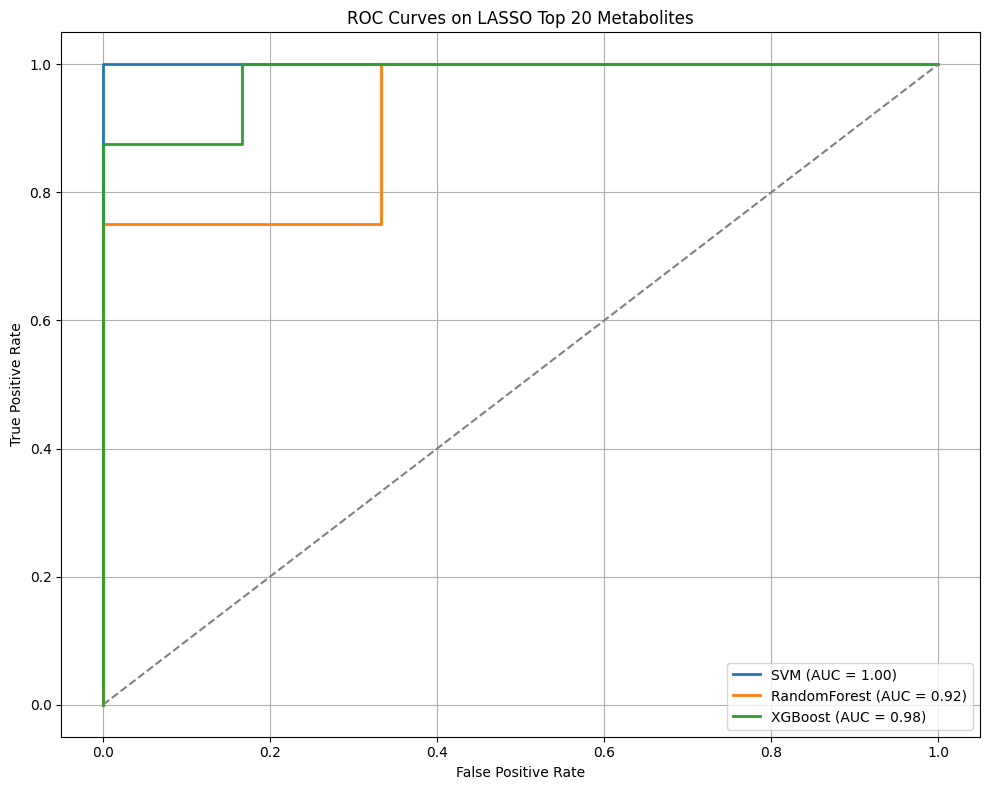


=== LASSO Feature Set: Model Evaluation ===
          Model  Accuracy  Precision  Recall        F1       AUC
0           SVM  1.000000   1.000000    1.00  1.000000  1.000000
1  RandomForest  0.714286   0.750000    0.75  0.750000  0.916667
2       XGBoost  0.928571   0.888889    1.00  0.941176  0.979167


In [20]:
#Train SVM, Random Forest, XGBoost on LASSO Selected Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load BL dataset
bl_df = pd.read_csv(data_dir + 'fbni_shared_cols_BL.csv')

# Load LASSO Top 20 features (force to string to match column names)
lasso_feats = pd.read_csv(data_dir + 'top20_lasso.csv')['Feature'].astype(str).tolist()

# Prepare data
X = bl_df[lasso_feats]
y = LabelEncoder().fit_transform(bl_df['Class'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train and Evaluate Each Model ---
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_preds = model.predict(X_test_scaled)

    # Metrics
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Save results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on LASSO Top 20 Metabolites')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Evaluation Table
results_df = pd.DataFrame(results)
print("\n=== LASSO Feature Set: Model Evaluation ===")
print(results_df)


Save Results and Plot Confusion Matrices


Model comparison results saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/lasso_top20_model_comparison.csv
ROC curve saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/lasso_top20_roc_curve.png


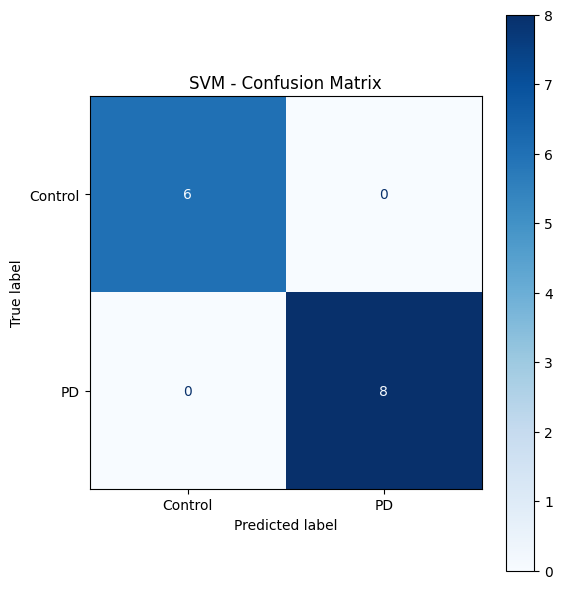

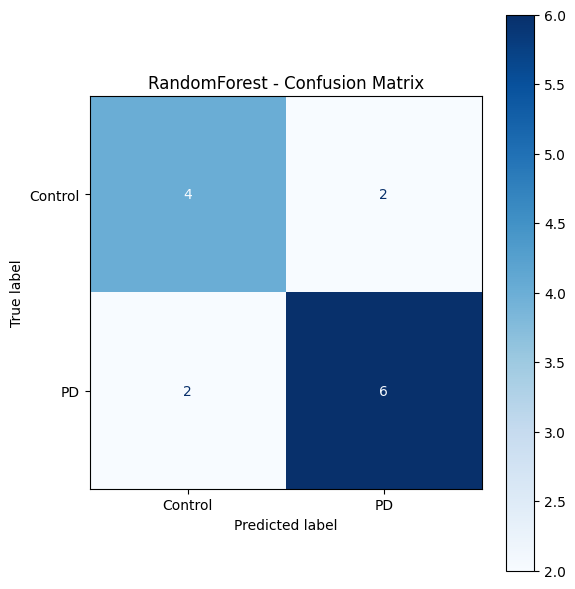

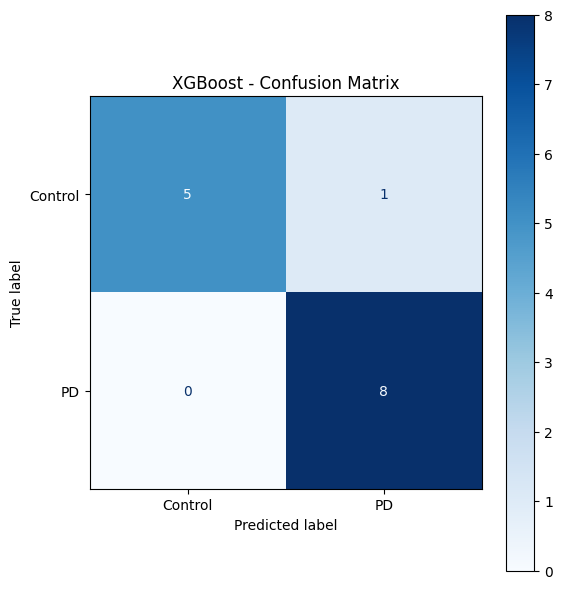

In [21]:
# --- Save Results and Plot Confusion Matrices ---

# 1. Save Evaluation Results to CSV
results_df.to_csv(data_dir + 'lasso_top20_model_comparison.csv', index=False)
print(f"\nModel comparison results saved to: {data_dir}lasso_top20_model_comparison.csv")

# 2. Save ROC Curve Plot
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on LASSO Top 20 Metabolites')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(data_dir + 'lasso_top20_roc_curve.png')
plt.close()
print(f"ROC curve saved to: {data_dir}lasso_top20_roc_curve.png")

# 3. Plot Confusion Matrices
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


#Train SVM, Random Forest, XGBoost on V06 Top 20 LASSO Features

LASSO Top 20 Features for V06 saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/top20_lasso_v06.csv


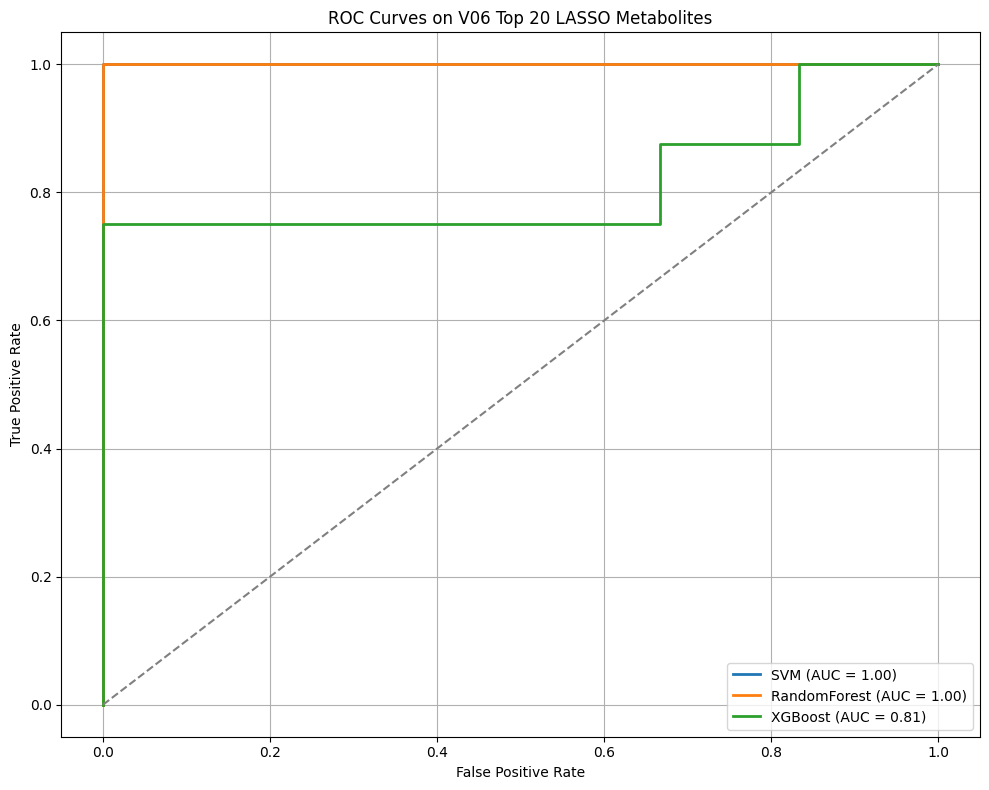


=== V06 LASSO Feature Set: Model Evaluation ===
          Model  Accuracy  Precision  Recall        F1     AUC
0           SVM  0.928571        1.0   0.875  0.933333  1.0000
1  RandomForest  0.928571        1.0   0.875  0.933333  1.0000
2       XGBoost  0.785714        1.0   0.625  0.769231  0.8125

Model comparison results saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/v06_lasso_top20_model_comparison.csv


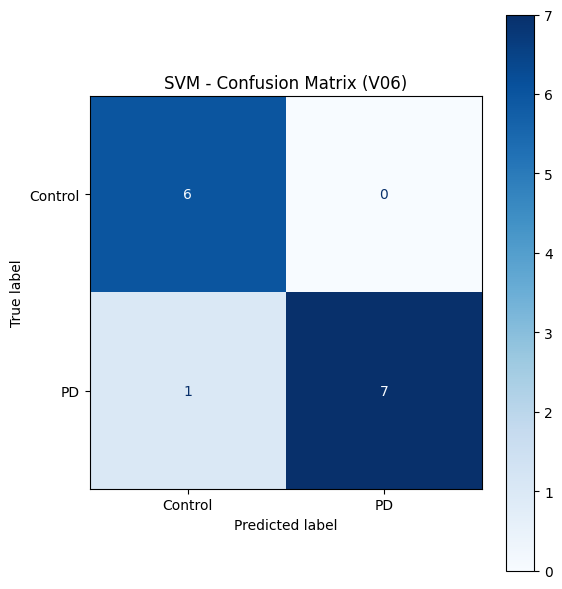

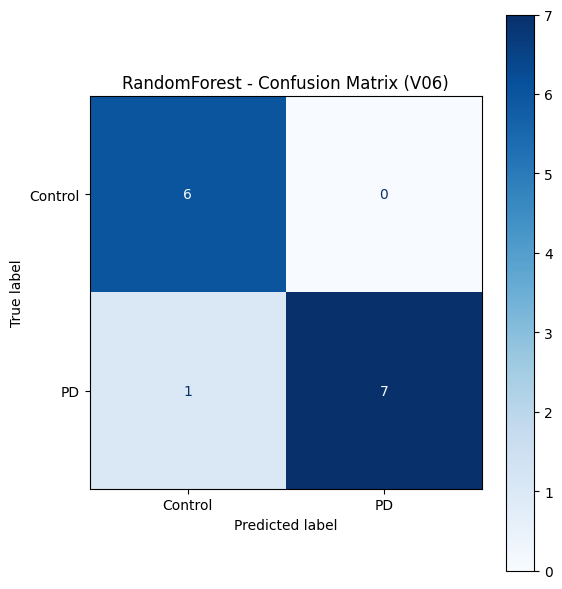

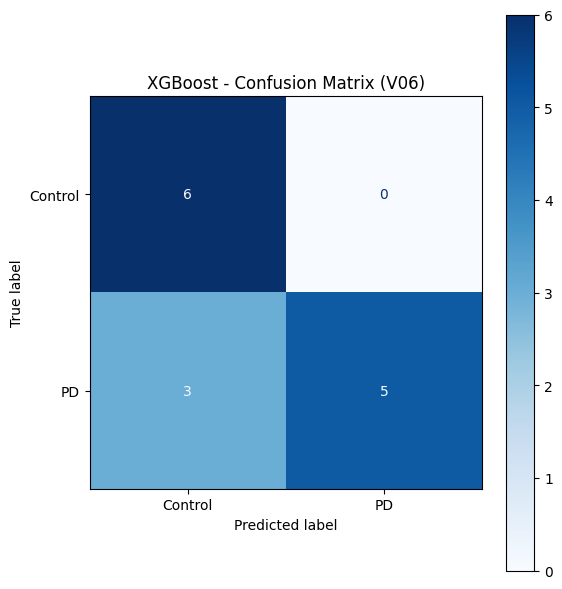

In [22]:
# --- Train SVM, Random Forest, XGBoost on V06 Top 20 LASSO Features ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load V06 dataset
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# Prepare data
X_v06 = v06_df.drop(columns=['Class'])
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])

feature_names = X_v06.columns
X_v06_scaled = StandardScaler().fit_transform(X_v06)

# --- LASSO Feature Selection on V06 ---
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
lasso_model.fit(X_v06_scaled, y_v06)
lasso_coefs = np.abs(lasso_model.coef_[0])

top20_lasso_v06 = list(pd.Series(lasso_coefs, index=feature_names).sort_values(ascending=False).head(20).index)

# Save Top 20 LASSO Features
pd.DataFrame({'Feature': top20_lasso_v06}).to_csv(data_dir + 'top20_lasso_v06.csv', index=False)
print(f"LASSO Top 20 Features for V06 saved to: {data_dir}top20_lasso_v06.csv")

# Subset data to LASSO top 20
X = v06_df[top20_lasso_v06]
y = y_v06

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train and Evaluate Each Model ---
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_preds = model.predict(X_test_scaled)

    # Metrics
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    # Save results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on V06 Top 20 LASSO Metabolites')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(data_dir + 'v06_lasso_top20_roc_curve.png')
plt.show()

# Print Evaluation Table
results_df = pd.DataFrame(results)
print("\n=== V06 LASSO Feature Set: Model Evaluation ===")
print(results_df)

# Save evaluation table
results_df.to_csv(data_dir + 'v06_lasso_top20_model_comparison.csv', index=False)
print(f"\nModel comparison results saved to: {data_dir}v06_lasso_top20_model_comparison.csv")

# --- Plot Confusion Matrices ---
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - Confusion Matrix (V06)')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


#Feature Selection Top 20 on V06 Dataset (MI, Boruta, LASSO, SHAP, Permutation)

In [23]:
# --- Feature Selection Top 20 on V06 Dataset (MI, Boruta, LASSO, SHAP, Permutation) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
import shap

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load V06 dataset
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# Prepare data
X_v06 = v06_df.drop(columns=['Class'])
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])
feature_names = X_v06.columns
X_v06_scaled = StandardScaler().fit_transform(X_v06)

# --- Mutual Information (MI) ---
mi_scores = mutual_info_classif(X_v06_scaled, y_v06, random_state=42)
top20_mi_v06 = list(pd.Series(mi_scores, index=feature_names).sort_values(ascending=False).head(20).index)
pd.DataFrame({'Feature': top20_mi_v06}).to_csv(data_dir + 'top20_mi_v06.csv', index=False)

# --- Boruta ---
rf_boruta = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=5)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', random_state=42, verbose=0)
boruta_selector.fit(X_v06_scaled, y_v06)
top20_boruta_v06 = list(np.array(feature_names)[boruta_selector.support_])[:20]
pd.DataFrame({'Feature': top20_boruta_v06}).to_csv(data_dir + 'top20_boruta_v06.csv', index=False)

# --- LASSO ---
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
lasso.fit(X_v06_scaled, y_v06)
lasso_coefs = np.abs(lasso.coef_[0])
top20_lasso_v06 = list(pd.Series(lasso_coefs, index=feature_names).sort_values(ascending=False).head(20).index)
pd.DataFrame({'Feature': top20_lasso_v06}).to_csv(data_dir + 'top20_lasso_v06.csv', index=False)

# --- SHAP (using XGBoost) ---
xgb_model = XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                          n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
xgb_model.fit(X_v06_scaled, y_v06)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_v06_scaled)
shap_importance = np.abs(shap_values.values).mean(axis=0)
top20_shap_v06 = list(pd.Series(shap_importance, index=feature_names).sort_values(ascending=False).head(20).index)
pd.DataFrame({'Feature': top20_shap_v06}).to_csv(data_dir + 'top20_shap_v06.csv', index=False)

# --- Permutation Importance (using RandomForest) ---
rf_perm = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_perm.fit(X_v06_scaled, y_v06)
perm = permutation_importance(rf_perm, X_v06_scaled, y_v06, n_repeats=30, random_state=42, n_jobs=-1)
top20_perm_v06 = list(pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False).head(20).index)
pd.DataFrame({'Feature': top20_perm_v06}).to_csv(data_dir + 'top20_permutation_v06.csv', index=False)

# --- Print Top 20 Features for Each Method ---
print("\nTop 20 Features by Mutual Information (V06):")
print(top20_mi_v06)

print("\nTop 20 Features by Boruta (V06):")
print(top20_boruta_v06)

print("\nTop 20 Features by LASSO (V06):")
print(top20_lasso_v06)

print("\nTop 20 Features by SHAP (V06):")
print(top20_shap_v06)

print("\nTop 20 Features by Permutation Importance (V06):")
print(top20_perm_v06)

print("\n✅ All top 20 feature lists saved into:", data_dir)



Top 20 Features by Mutual Information (V06):
['100021015', '100021208', '100008984', '100001569', '892', '100020371', '999911843', '100010896', '935', '891', '100002008', '999921353', '1134', '100022006', '100001402', '100004243', '100021198', '272', '827', '999912839']

Top 20 Features by Boruta (V06):
['100021726', '999912830']

Top 20 Features by LASSO (V06):
['100015666', '100002185', '999921845', '999917010', '999916087', '100000580', '100001755', '100001987', '100003892', '100021140', '100004182', '100001624', '999913658', '100004091', '181', '100020378', '100021324', '241', '100021015', '999912740']

Top 20 Features by SHAP (V06):
['100021726', '999916087', '100000463', '100002185', '100000840', '999912830', '100000011', '999911850', '100019972', '999917325', '100002796', '241', '100010936', '100015832', '100003892', '563', '999923276', '100006378', '999925343', '100009406']

Top 20 Features by Permutation Importance (V06):
['999926119', '100000007', '100000008', '100000010', '

#Create Feature Selection Comparison CSV for V06

In [25]:
# --- Create Feature Selection Comparison CSV for V06 ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load V06 dataset
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')
X_v06 = v06_df.drop(columns=['Class'])
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])

# Scale full V06 data
scaler = StandardScaler()
X_v06_scaled = scaler.fit_transform(X_v06)
X_v06 = pd.DataFrame(X_v06_scaled, columns=X_v06.columns)

# Load Top 20 features for each method
top20_mi = pd.read_csv(data_dir + 'top20_mi_v06.csv')['Feature'].astype(str).tolist()
top20_boruta = pd.read_csv(data_dir + 'top20_boruta_v06.csv')['Feature'].astype(str).tolist()
top20_lasso = pd.read_csv(data_dir + 'top20_lasso_v06.csv')['Feature'].astype(str).tolist()
top20_shap = pd.read_csv(data_dir + 'top20_shap_v06.csv')['Feature'].astype(str).tolist()
top20_perm = pd.read_csv(data_dir + 'top20_permutation_v06.csv')['Feature'].astype(str).tolist()

# Organize feature sets
feature_sets = {
    'MI': top20_mi,
    'Boruta': top20_boruta,
    'LASSO': top20_lasso,
    'SHAP': top20_shap,
    'Permutation': top20_perm
}

results = []

# Quick model for evaluation
base_model = XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                           n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)

# --- Evaluate each feature selection ---
for method, features in feature_sets.items():
    # Only evaluate if features exist (Boruta sometimes has very few)
    if len(features) > 0:
        X = v06_df[features]
        y = y_v06

        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train model
        base_model.fit(X_train_scaled, y_train)
        y_probs = base_model.predict_proba(X_test_scaled)[:, 1]
        y_preds = base_model.predict(X_test_scaled)

        # Metrics
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        acc = accuracy_score(y_test, y_preds)
        prec = precision_score(y_test, y_preds)
        rec = recall_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds)

        # Save
        results.append({
            'Feature_Selection': method,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1,
            'AUC': roc_auc
        })

# --- Save and Print ---
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir + 'feature_selection_comparison_v06.csv', index=False)

print("\n=== Feature Selection Comparison (V06) ===")
print(results_df)
print(f"\nSaved to: {data_dir}feature_selection_comparison_v06.csv")



=== Feature Selection Comparison (V06) ===
  Feature_Selection  Accuracy  Precision  Recall        F1       AUC
0                MI  0.571429   0.666667   0.500  0.571429  0.520833
1            Boruta  0.642857   1.000000   0.375  0.545455  0.916667
2             LASSO  0.785714   1.000000   0.625  0.769231  0.812500
3              SHAP  0.857143   1.000000   0.750  0.857143  0.937500
4       Permutation  0.357143   0.333333   0.125  0.181818  0.458333

Saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/feature_selection_comparison_v06.csv


#V06 Feature and Model AUC Comparison Plots

<ipython-input-26-d9403ba9c449>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUC', data=model_results_v06, palette='Purples_d')


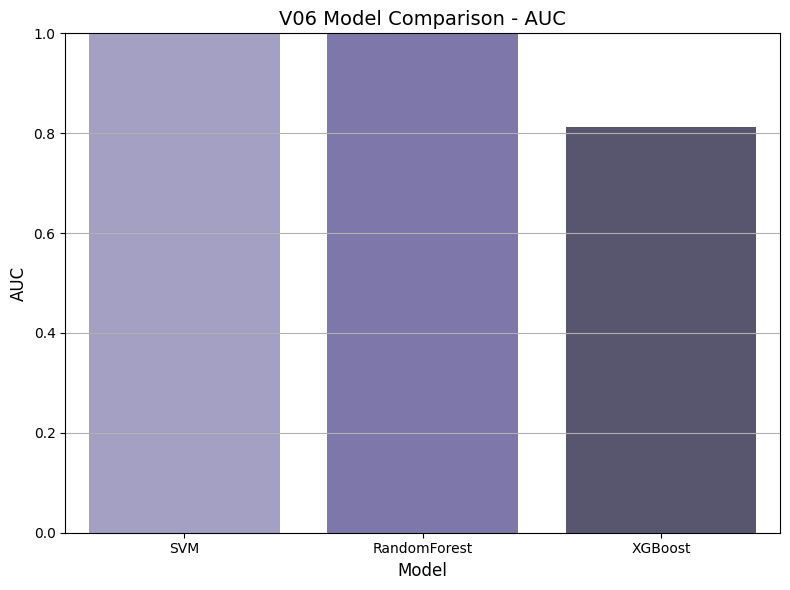


Model Comparison AUC Barplot saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/v06_lasso_top20_model_auc_barplot.png


<ipython-input-26-d9403ba9c449>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature_Selection', y='AUC', data=feature_results_v06, palette='Oranges_d')


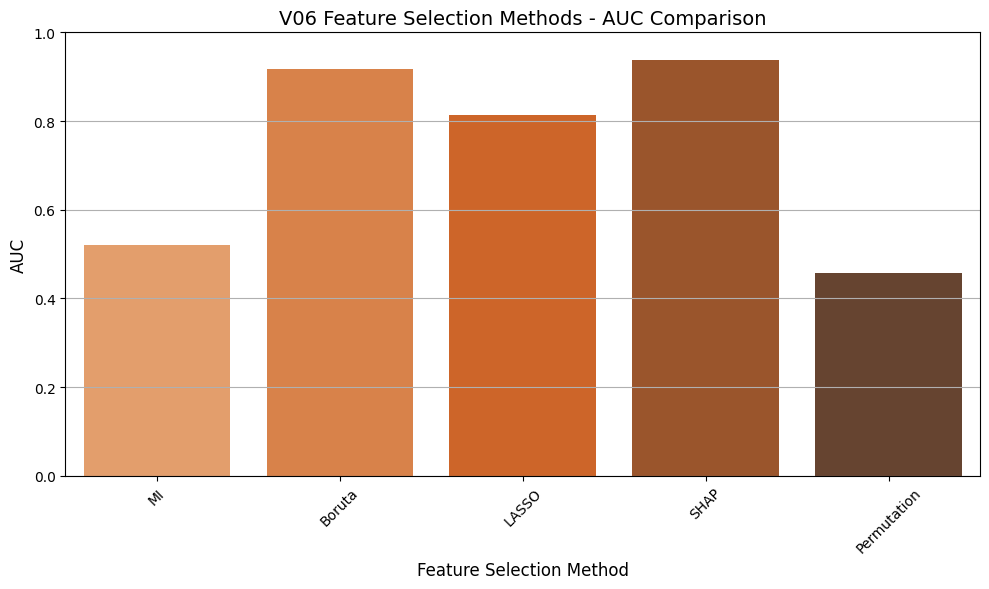


Feature Selection AUC Barplot saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/v06_feature_selection_auc_barplot.png


In [26]:
# --- V06: Feature and Model Comparison AUC Barplots ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load results
# (Feature Selection comparison for V06 may not exist as CSV if we skipped it, but Model comparison exists)
model_results_v06 = pd.read_csv(data_dir + 'v06_lasso_top20_model_comparison.csv')

# --- 1. Plot Model Comparison (V06) ---
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='AUC', data=model_results_v06, palette='Purples_d')
plt.title('V06 Model Comparison - AUC', fontsize=14)
plt.ylabel('AUC', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(data_dir + 'v06_lasso_top20_model_auc_barplot.png')
plt.show()

print(f"\nModel Comparison AUC Barplot saved to: {data_dir}v06_lasso_top20_model_auc_barplot.png")

# --- 2. Plot Feature Selection Comparison (V06) if CSV exists ---
try:
    feature_results_v06 = pd.read_csv(data_dir + 'feature_selection_comparison_v06.csv')

    plt.figure(figsize=(10,6))
    sns.barplot(x='Feature_Selection', y='AUC', data=feature_results_v06, palette='Oranges_d')
    plt.title('V06 Feature Selection Methods - AUC Comparison', fontsize=14)
    plt.ylabel('AUC', fontsize=12)
    plt.xlabel('Feature Selection Method', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(data_dir + 'v06_feature_selection_auc_barplot.png')
    plt.show()

    print(f"\nFeature Selection AUC Barplot saved to: {data_dir}v06_feature_selection_auc_barplot.png")

except FileNotFoundError:
    print("\nNo feature_selection_comparison_v06.csv found. Skipping Feature Selection AUC Plot.")


#Evaluation (SVM, RF, XGB) - Train Full BL and Test V06

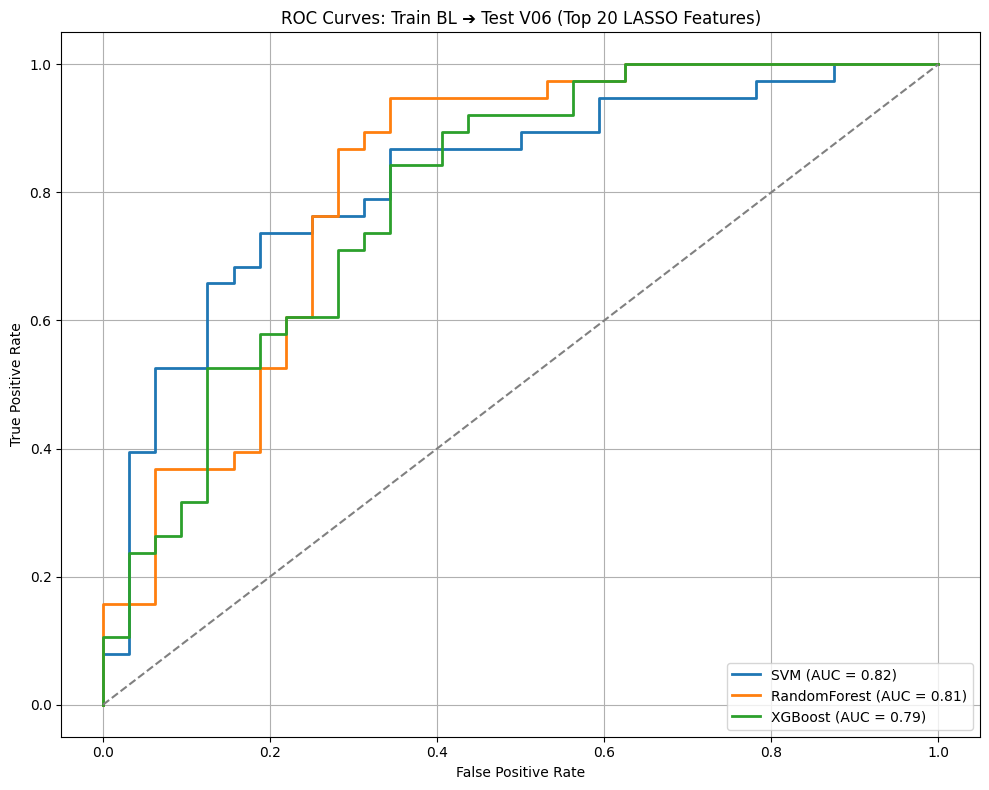


=== Final Evaluation: Train BL ➔ Test V06 (All 3 Models) ===
          Model  Accuracy  Precision    Recall        F1       AUC
0           SVM  0.757143   0.783784  0.763158  0.773333  0.821546
1  RandomForest  0.785714   0.780488  0.842105  0.810127  0.814967
2       XGBoost  0.714286   0.725000  0.763158  0.743590  0.794408

Final model comparison saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/final_bl_to_v06_3models_comparison.csv


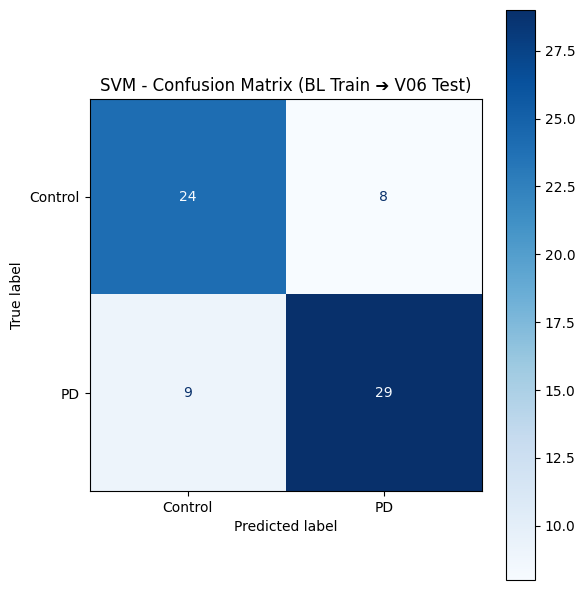

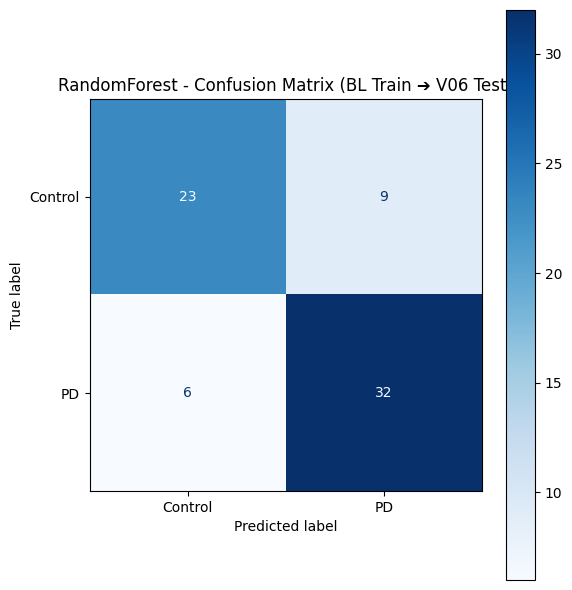

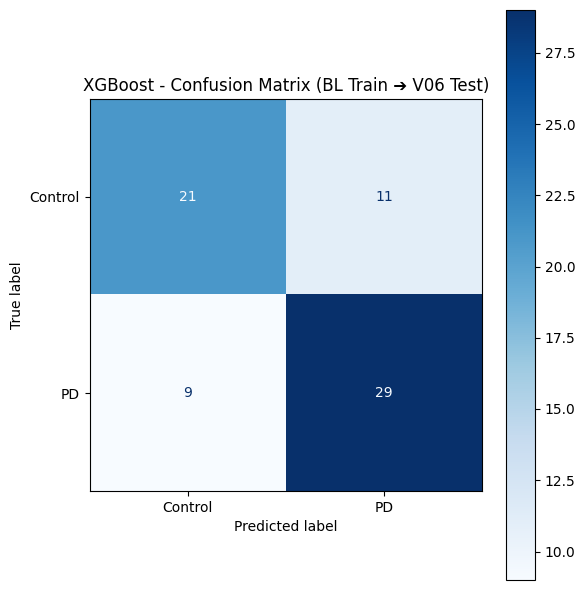

In [28]:
# --- Final Evaluation: Train Full BL (Top 20 LASSO) ➔ Test Full V06 ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# --- Load datasets ---
bl_df = pd.read_csv(data_dir + 'fbni_shared_cols_BL.csv')
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# --- Load Top 20 LASSO features from BL ---
lasso_feats_bl = pd.read_csv(data_dir + 'top20_lasso.csv')['Feature'].astype(str).tolist()

# --- Prepare BL (Train) Data ---
X_bl = bl_df[lasso_feats_bl]
y_bl = LabelEncoder().fit_transform(bl_df['Class'])

# --- Prepare V06 (Test) Data ---
X_v06 = v06_df[lasso_feats_bl]  # Note: use same features from BL LASSO
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])

# --- Scale features ---
scaler = StandardScaler()
X_bl_scaled = scaler.fit_transform(X_bl)
X_v06_scaled = scaler.transform(X_v06)

# --- Define Models ---
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train and Evaluate Each Model ---
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    # Train
    model.fit(X_bl_scaled, y_bl)
    # Predict
    y_probs = model.predict_proba(X_v06_scaled)[:, 1]
    y_preds = model.predict(X_v06_scaled)

    # Metrics
    fpr, tpr, _ = roc_curve(y_v06, y_probs)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_v06, y_preds)
    prec = precision_score(y_v06, y_preds)
    rec = recall_score(y_v06, y_preds)
    f1 = f1_score(y_v06, y_preds)

    # Save results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Train BL ➔ Test V06 (Top 20 LASSO Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(data_dir + 'final_roc_bl_to_v06_3models.png')
plt.show()

# --- Save and Print Final Results ---
results_df = pd.DataFrame(results)
print("\n=== Final Evaluation: Train BL ➔ Test V06 (All 3 Models) ===")
print(results_df)

results_df.to_csv(data_dir + 'final_bl_to_v06_3models_comparison.csv', index=False)
print(f"\nFinal model comparison saved to: {data_dir}final_bl_to_v06_3models_comparison.csv")

# --- Plot Confusion Matrices ---
for model_name, model in models.items():
    model.fit(X_bl_scaled, y_bl)
    y_preds = model.predict(X_v06_scaled)
    cm = confusion_matrix(y_v06, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - Confusion Matrix (BL Train ➔ V06 Test)')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(data_dir + f'final_cm_bl_to_v06_{model_name.lower()}.png')
    plt.show()


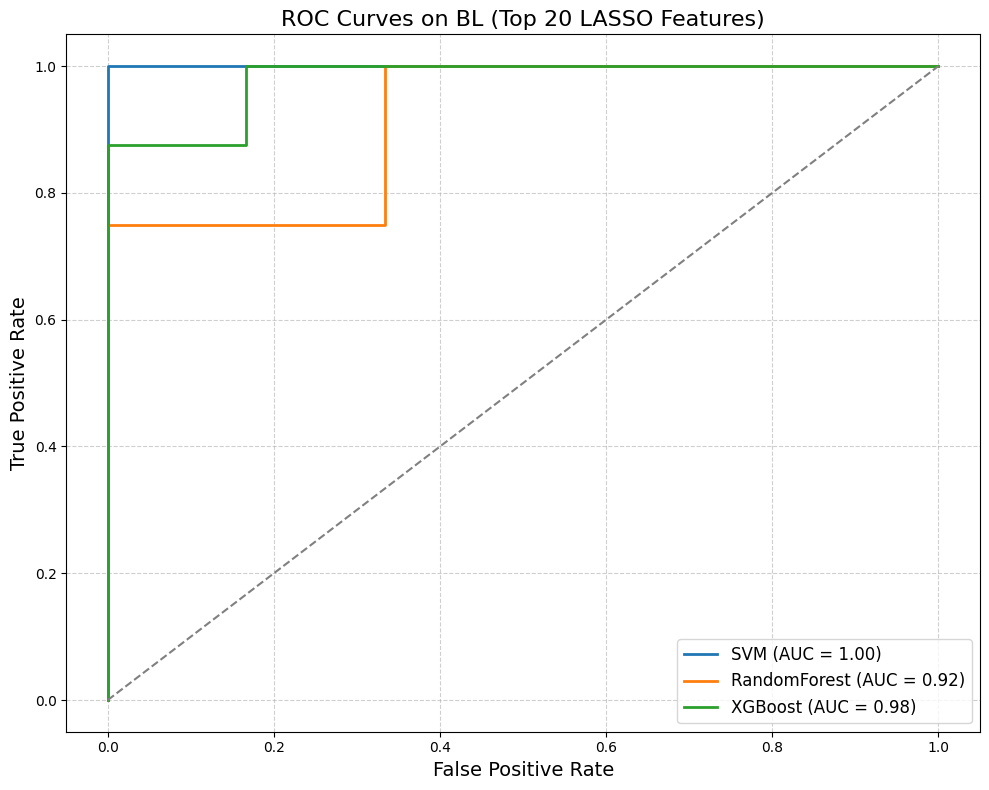

In [29]:
# --- AUC-ROC Curve Plot for SVM, RF, XGB on BL ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load BL dataset
bl_df = pd.read_csv(data_dir + 'fbni_shared_cols_BL.csv')

# Load Top 20 features (LASSO selected) — you could swap for RFE Top 20 if you prefer
lasso_feats_bl = pd.read_csv(data_dir + 'top20_lasso.csv')['Feature'].astype(str).tolist()

# Prepare data
X = bl_df[lasso_feats_bl]
y = LabelEncoder().fit_transform(bl_df['Class'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

# Plot ROC Curves
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves on BL (Top 20 LASSO Features)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


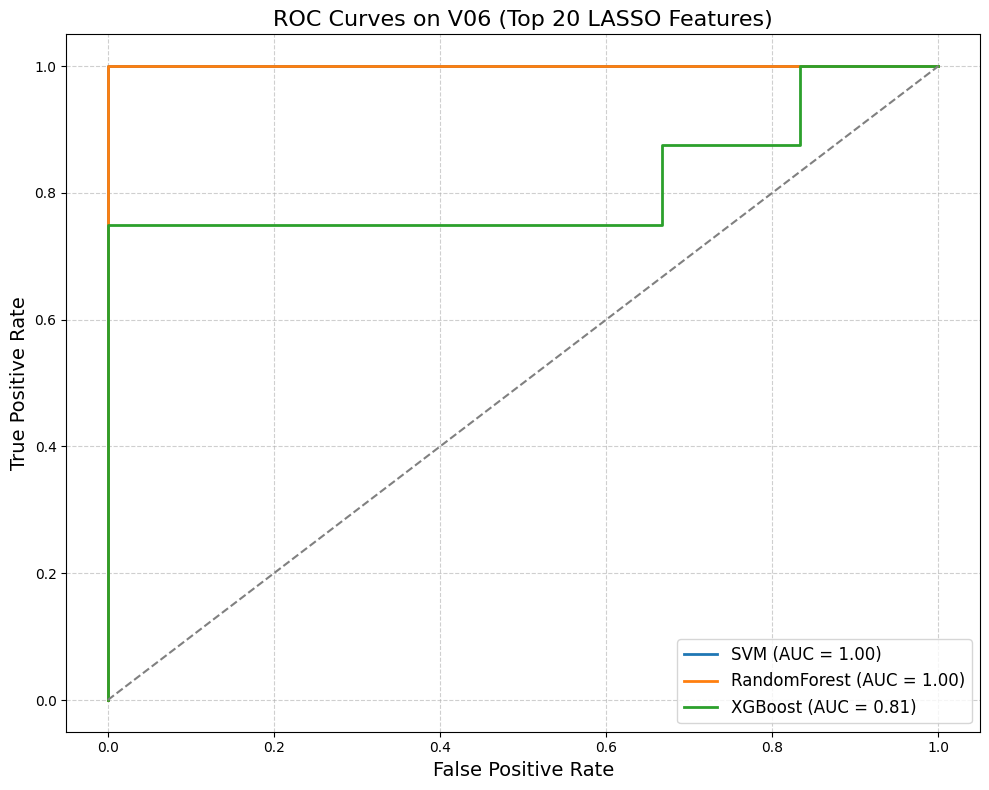


ROC Curve saved to: /content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/v06_lasso_top20_roc_curve.png


In [32]:
# --- AUC-ROC Curve Plot for SVM, RF, XGB on V06 (Save + Show) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load V06 dataset
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# Load Top 20 features for V06 (LASSO selected)
lasso_feats_v06 = pd.read_csv(data_dir + 'top20_lasso_v06.csv')['Feature'].astype(str).tolist()

# Prepare data
X = v06_df[lasso_feats_v06]
y = LabelEncoder().fit_transform(v06_df['Class'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

# Plot ROC Curves
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize Plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves on V06 (Top 20 LASSO Features)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plt.savefig(data_dir + 'v06_lasso_top20_roc_curve.png', dpi=300)

# Show the plot
plt.show()

print(f"\nROC Curve saved to: {data_dir}v06_lasso_top20_roc_curve.png")


#Using SHAP for BL

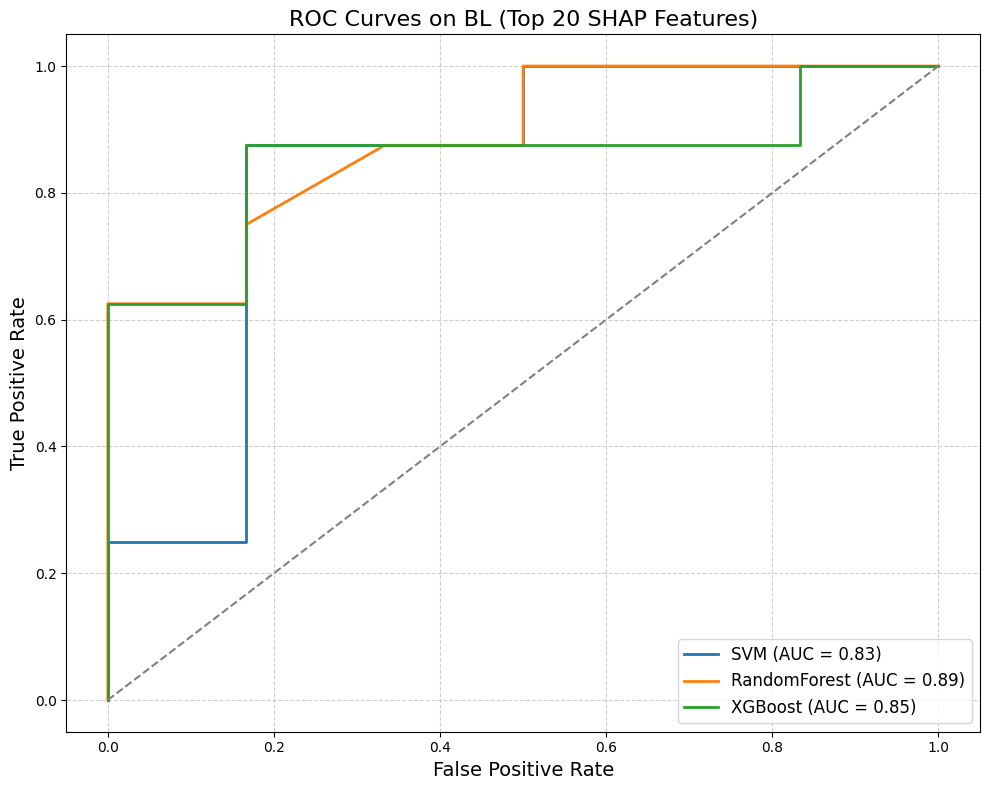


=== BL Top 20 SHAP Features: Model Evaluation ===
          Model  Accuracy  Precision  Recall   F1       AUC
0           SVM  0.785714   0.857143    0.75  0.8  0.833333
1  RandomForest  0.785714   0.857143    0.75  0.8  0.885417
2       XGBoost  0.785714   0.857143    0.75  0.8  0.854167


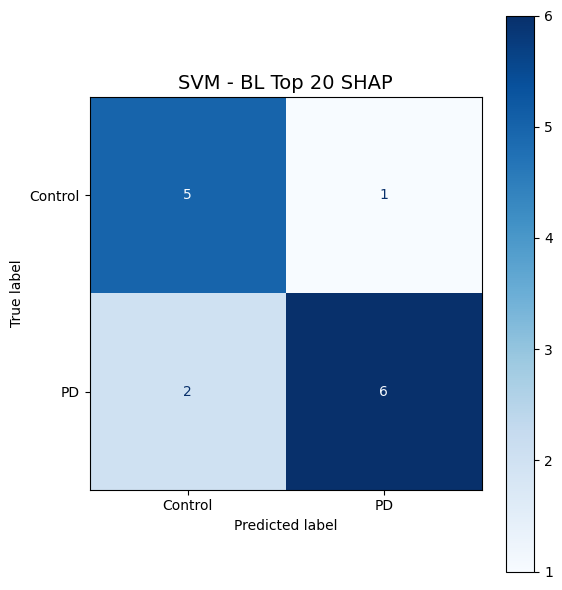

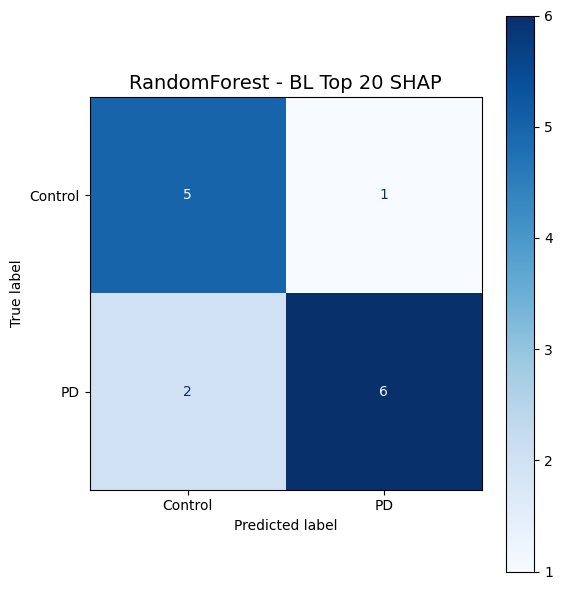

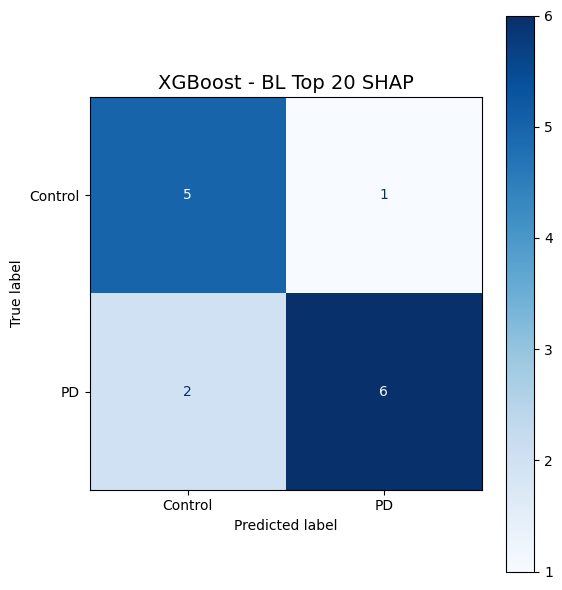

In [40]:
# --- Train SVM, RF, XGB on BL Top 20 SHAP Features ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load BL dataset
bl_df = pd.read_csv(data_dir + 'fbni_shared_cols_BL.csv')

# Load Top 20 SHAP features (for BL)
shap_feats_bl = pd.read_csv(data_dir + 'top20_shap_bl.csv')['Feature'].astype(str).tolist()

# Prepare data
X = bl_df[shap_feats_bl]
y = LabelEncoder().fit_transform(bl_df['Class'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train, Evaluate, and Plot ROC ---
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_preds = model.predict(X_test_scaled)

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves on BL (Top 20 SHAP Features)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(data_dir + 'bl_top20_shap_roc_curve.png', dpi=300)
plt.show()

# --- Save Evaluation Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir + 'bl_top20_shap_model_comparison.csv', index=False)
print("\n=== BL Top 20 SHAP Features: Model Evaluation ===")
print(results_df)

# --- Plot Confusion Matrices ---
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - BL Top 20 SHAP', fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(data_dir + f'bl_top20_shap_cm_{model_name.lower()}.png', dpi=300)
    plt.show()


#Using SHAP for V06

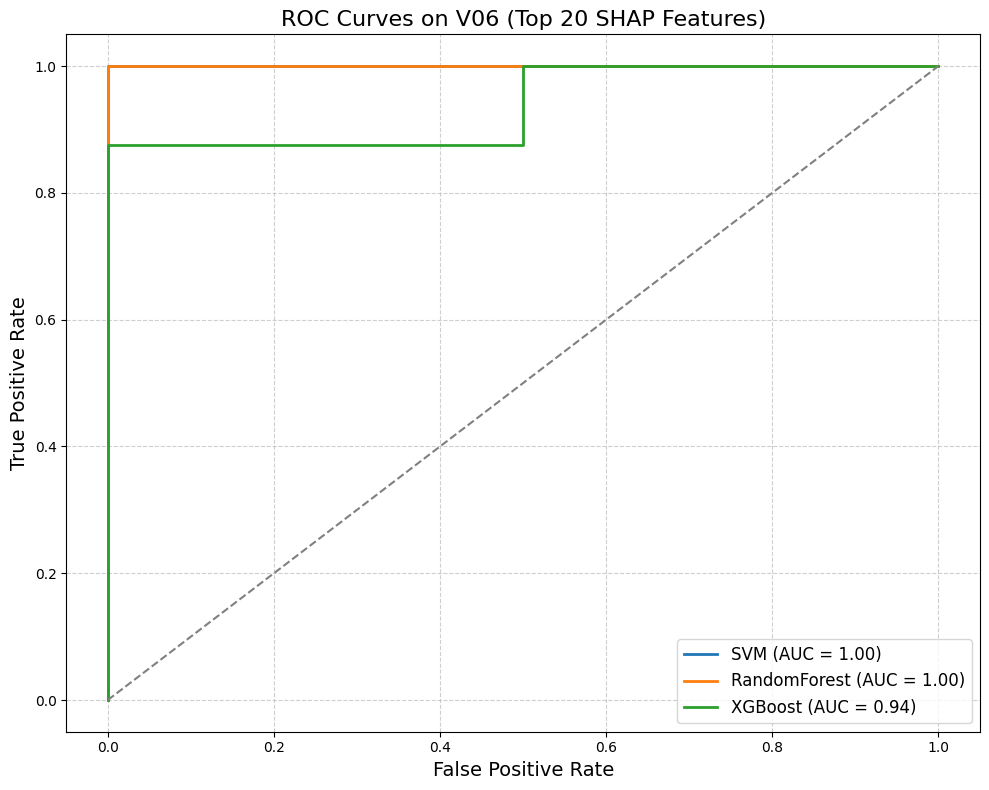


=== V06 Top 20 SHAP Features: Model Evaluation ===
          Model  Accuracy  Precision  Recall        F1     AUC
0           SVM  0.857143        1.0   0.750  0.857143  1.0000
1  RandomForest  0.928571        1.0   0.875  0.933333  1.0000
2       XGBoost  0.857143        1.0   0.750  0.857143  0.9375


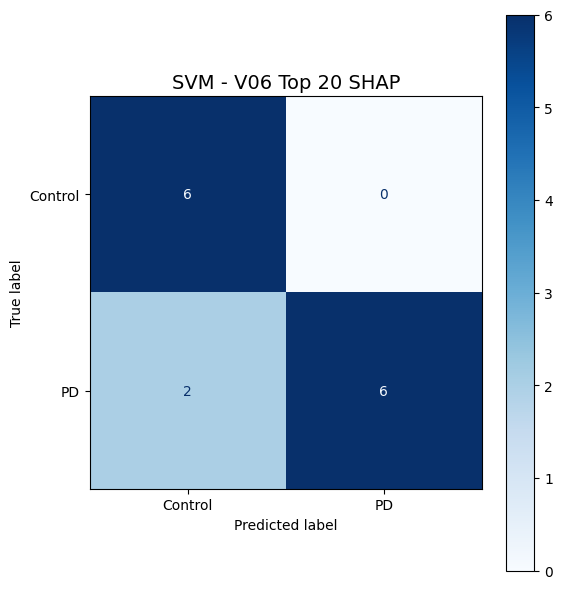

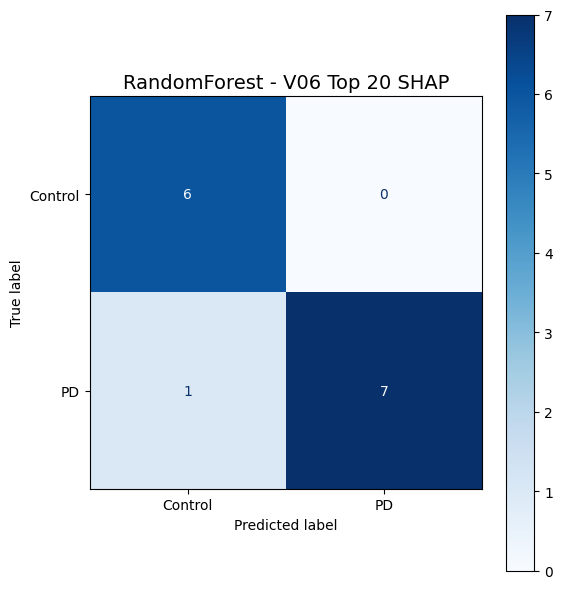

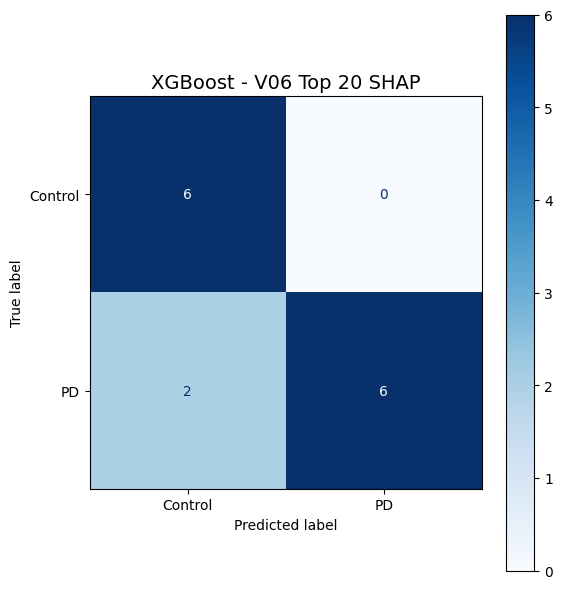

In [39]:
# --- Train SVM, RF, XGB on V06 Top 20 SHAP Features ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load V06 dataset
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# Load Top 20 SHAP features (for V06)
shap_feats_v06 = pd.read_csv(data_dir + 'top20_shap_v06.csv')['Feature'].astype(str).tolist()

# Prepare data
X = v06_df[shap_feats_v06]
y = LabelEncoder().fit_transform(v06_df['Class'])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train, Evaluate, and Plot ROC ---
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_preds = model.predict(X_test_scaled)

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds)
    rec = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves on V06 (Top 20 SHAP Features)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(data_dir + 'v06_top20_shap_roc_curve.png', dpi=300)
plt.show()

# --- Save Evaluation Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir + 'v06_top20_shap_model_comparison.csv', index=False)
print("\n=== V06 Top 20 SHAP Features: Model Evaluation ===")
print(results_df)

# --- Plot Confusion Matrices ---
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - V06 Top 20 SHAP', fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(data_dir + f'v06_top20_shap_cm_{model_name.lower()}.png', dpi=300)
    plt.show()


#Train on BL, Test on V06 using BL Top 20 SHAP Features

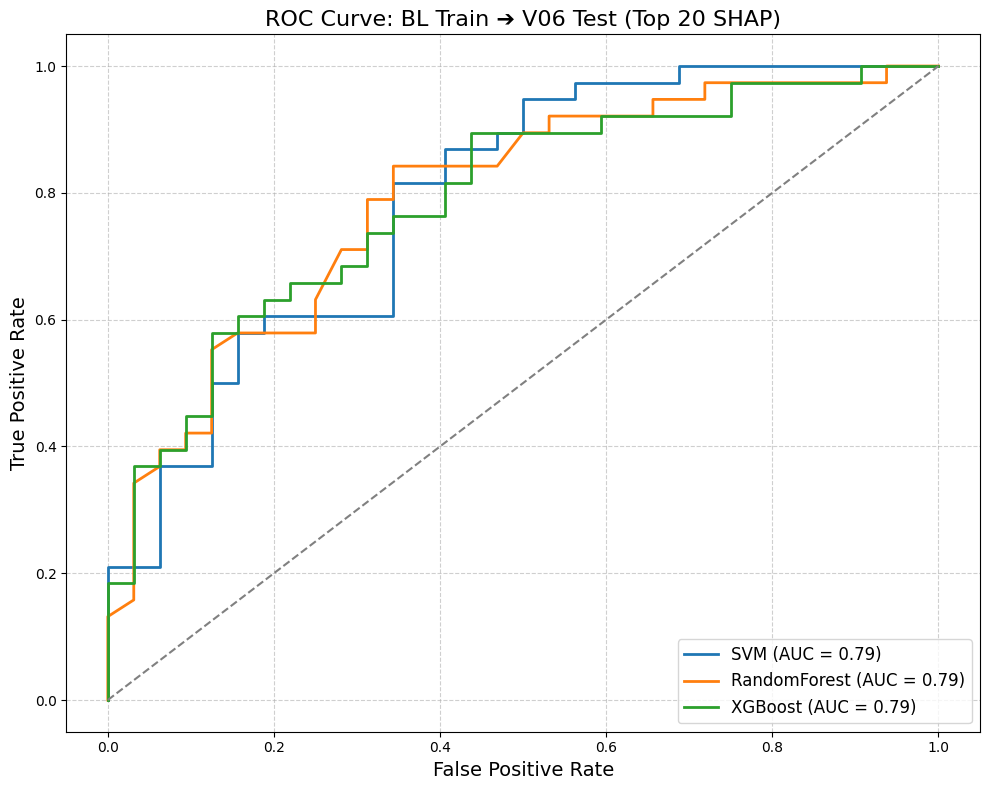


=== BL Train ➔ V06 Test: Top 20 SHAP Features - Model Evaluation ===
          Model  Accuracy  Precision    Recall        F1       AUC
0           SVM  0.728571   0.731707  0.789474  0.759494  0.791118
1  RandomForest  0.742857   0.750000  0.789474  0.769231  0.791118
2       XGBoost  0.700000   0.707317  0.763158  0.734177  0.788651


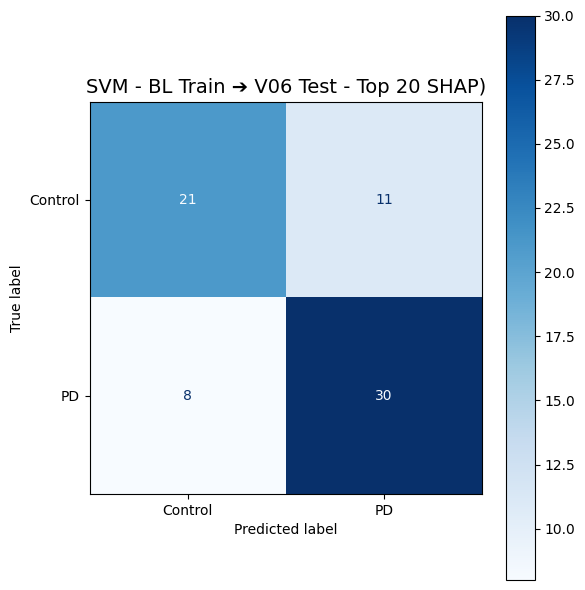

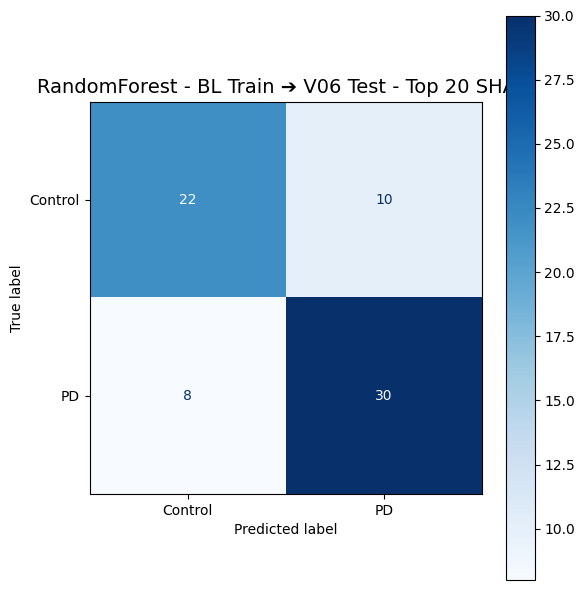

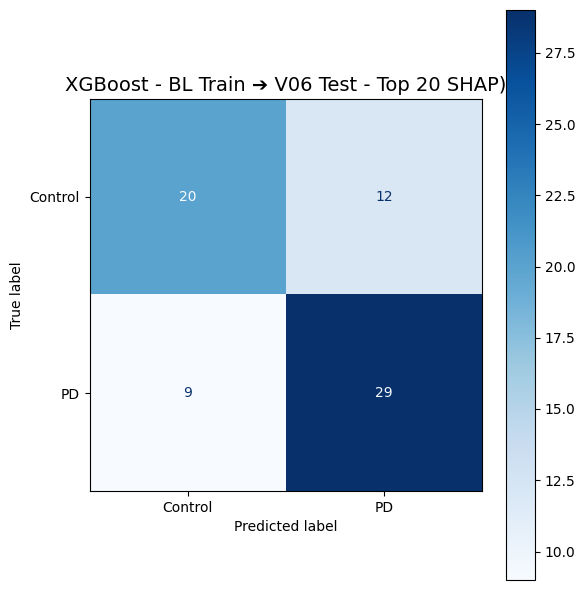

In [38]:
# --- Train on BL, Test on V06 using BL Top 20 SHAP Features ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Paths
data_dir = '/content/drive/MyDrive/CSC-587/Milestone/Milestone2/data/'

# Load BL and V06 datasets
bl_df = pd.read_csv(data_dir + 'fbni_shared_cols_BL.csv')
v06_df = pd.read_csv(data_dir + 'fbni_shared_cols_V06.csv')

# Load Top 20 SHAP features selected from BL
shap_feats_bl = pd.read_csv(data_dir + 'top20_shap_bl.csv')['Feature'].astype(str).tolist()

# Prepare BL data (train)
X_bl = bl_df[shap_feats_bl]
y_bl = LabelEncoder().fit_transform(bl_df['Class'])

# Prepare V06 data (test)
X_v06 = v06_df[shap_feats_bl]  # Same features!
y_v06 = LabelEncoder().fit_transform(v06_df['Class'])

# Scale features
scaler = StandardScaler()
X_bl_scaled = scaler.fit_transform(X_bl)
X_v06_scaled = scaler.transform(X_v06)

# Define Models
models = {
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42,
                              n_estimators=100, max_depth=4, learning_rate=0.1, subsample=0.8)
}

results = []

# --- Train on BL, Test on V06, and Plot ROC ---
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    model.fit(X_bl_scaled, y_bl)
    y_probs = model.predict_proba(X_v06_scaled)[:, 1]
    y_preds = model.predict(X_v06_scaled)

    # ROC
    fpr, tpr, _ = roc_curve(y_v06, y_probs)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    acc = accuracy_score(y_v06, y_preds)
    prec = precision_score(y_v06, y_preds)
    rec = recall_score(y_v06, y_preds)
    f1 = f1_score(y_v06, y_preds)

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': roc_auc
    })

    # Plot ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', linewidth=2)

# Finalize ROC plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve: BL Train ➔ V06 Test (Top 20 SHAP)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(data_dir + 'bl_to_v06_top20_shap_roc_curve.png', dpi=300)
plt.show()

# --- Save Evaluation Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir + 'bl_to_v06_top20_shap_model_comparison.csv', index=False)
print("\n=== BL Train ➔ V06 Test: Top 20 SHAP Features - Model Evaluation ===")
print(results_df)

# --- Plot Confusion Matrices ---
for model_name, model in models.items():
    model.fit(X_bl_scaled, y_bl)
    y_preds = model.predict(X_v06_scaled)
    cm = confusion_matrix(y_v06, y_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'PD'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - BL Train ➔ V06 Test - Top 20 SHAP)', fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(data_dir + f'bl_to_v06_top20_shap_cm_{model_name.lower()}.png', dpi=300)
    plt.show()
